# Классификация
Автор: **[Булыгин Олег](https://olegtalks.ru/)**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

**Несбалансированный** набор данных (unbalanced dataset) — это выборка, в которой количества объектов каждого из классов значительно отличаются.

Очевидно, что такая проблема в первую очередь актуальна для задач классификации.

Зачем обращать внимание на несбалансированные данные? Вам может потребоваться применить определенный метод выборки, если у вас есть задача классификации с несбалансированным набором данных.

Рассмотрим следующий пример модели, обнаруживающей мошенничество. Случаи мошенничества происходят один раз на 200 транзакций в этом наборе данных, поэтому в истинном распределении около 0.5% данных являются положительными.

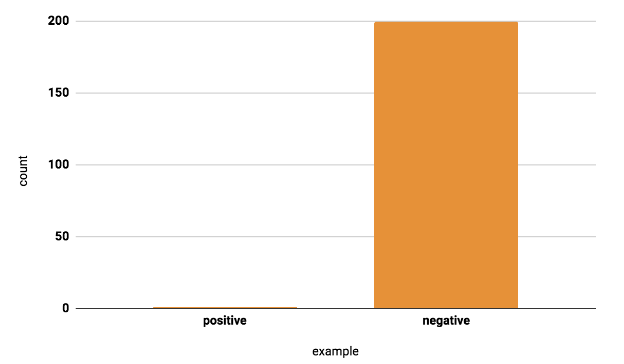

Почему это может быть проблематично?
При разбиении несбалансированной выборки на тренировочную/валидационную/тестовую увеличивается шанс попадания в одну из них объектов только одного класса, из-за чего оценка качества модели может быть необъективной.

*Accuracy очень плохой выбор для оценки моделей при дисбалансе классов.*

Поэтому используются метрики, которые концентрируются на каждом из классов отдельно, — это precision, recall и F1-score.

Также были разработаны специальные метрики, основанные на accuracy: это функционал Каппа Коэна (Cohen’s Kappa) и balanced accuracy. Подробнее о них вы можете прочитать [здесь](https://alexanderdyakonov.wordpress.com/2019/05/31/%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8B-%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0-%D0%B2-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5-%D0%B1%D0%B8%D0%BD%D0%B0%D1%80%D0%BD/).

А некоторые стандартные методы ML, такие как дерево решений и логистическая регрессия, имеют тенденцию игнорировать класс меньшинства.

In [ ]:
data = load_breast_cancer()
df = pd.DataFrame(data=data.data,
                  columns=data.feature_names)
df['class'] = data.target
df['class'] = df['class'].replace({0: 1, 1: 0})

In [ ]:
df['class'].value_counts(normalize=True)

Итак, около 63% пациентов имеют доброкачественную опухоль, а 37% - злокачественную. В реальных задачах можно столкнуться и с куда более неравномерными соотношениями, например 80/20, 90/10 или даже 99/1.

### Разделение выборок

Для начала проведём обычное случайное разбиение на тренировочную и тестовую выборки без стратификации:



In [ ]:
X, y = df.drop('class', axis=1), df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)
print('Тренировочная выборка:\n', y_train.value_counts(normalize=True), sep='')
print('Тестовая выборка:\n', y_test.value_counts(normalize=True), sep='')

Мы видим, что соотношения классов варьируется, что не есть хорошо. Давайте попробуем сбалансировать соотношения.

Для стратифицированного разбиения достаточно в функции `train_test_split()` задать параметр `stratify`, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами `y`.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print('Тренировочная выборка:\n', y_train.value_counts(normalize=True), sep='')
print('Тестовая выборка:\n', y_test.value_counts(normalize=True), sep='')

Теперь в каждом из наборов данных примерно одинаковые соотношения классов. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.

### StratifiedKFold

Но как организовать разбиение по методу k-fold и получить одинаковые соотношения классов при дисбалансе классов?

Для этого вместо KFold используется кросс-валидатор [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.



In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipeline = make_pipeline(StandardScaler(),
                         LogisticRegression(random_state=42,
                                            penalty='elasticnet',
                                            solver='saga',
                                            n_jobs=-1)) # поддерживает elasticnet

In [ ]:
param_grid = {
    'logisticregression__l1_ratio': np.linspace(0, 1, 10),
    'logisticregression__C': np.linspace(0, 100, 10)
}

gs = GridSearchCV(pipeline,
                  param_grid=param_grid,
                  cv=skf,
                  scoring='recall',
                  n_jobs=-1)


gs.fit(X_train, y_train)
print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшее качество на кросс-валидации: {gs.best_score_}')

## Напоминание о регуляризации

Во избежание переобучения модели в функцию потерь логистической регрессии так же может быть добавлена регуляризация. В реализации логистической регрессии в sklearn она немного отличается от того, что вы видели для линейной регрессии.

При L1-регуляризации мы добавляем в функцию потерь L(w) штраф из суммы модулей параметров, а саму функцию logloss умножаем на коэффициент C:

$$L(w)=C \cdot \log \operatorname{loss}+\sum_{j=1}^{m}\left|w_{j}\right| \rightarrow \min_{w}$$



А при L2-регуляризации — штраф из суммы квадратов параметров:

$$L(w)=C \cdot \log \operatorname{loss}+\sum_{j=1}^{m}\left(w_{j}\right)^{2} \rightarrow \min _{w}$$

Значение коэффициента C — коэффициент, обратный коэффициенту регуляризации. Чем больше C, тем меньше «сила» регуляризации.

Все эти страшные формулы уже реализованы в классических библиотеках, таких как sklearn. Но нам важно понимать принцип того, что происходит «под капотом», чтобы верно интерпретировать результат и по возможности управлять им.



In [ ]:
# Получаем предсказания на кросс-валидации
y_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

# Строим отчет о классификации
report = classification_report(y_train, y_pred)
print(report)

sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

Существует несколько способов уменьшить влияние дисбаланса на обучение модели:

- **Выбор порога вероятности**. Когда классы несбалансированы, модель может быть смещена в сторону класса большинства, что приводит к плохой производительности на классе меньшинства. Смещение порога вероятности позволяет настроить модель так, чтобы она лучше работала с классом меньшинства. Это мы обсудили ранее.

- **Взвешивание объектов**. В функцию ошибки добавляется штраф, прямо пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию.



- **Сэмплирование** (sampling) — перебалансировка выборки искусственным путём:
upsampling — искусственное увеличение количества объектов миноритарного класса;
downsampling — сокращение количества объектов мажоритарного класса.


### Смещение порога

Представим ситуацию, что онкодиагностика в клинике довольно дорогая. Но при этом нам важно выявить злокачественные опухоли у как можно большего числа людей (у которых они есть). То есть нам важен и precision, и recall.

Можем ли мы как-то улучшить метрики?

Давайте будем изменять порог принятия решений. По умолчанию в sklearn порог вероятности для моделей классификации составляет 0.5. То есть если вероятность наличия злокачественной опухоли у пациента выше 0.5, то модель относит его к к классу 1, а если меньше 0.5 — то к 0.


Но как будут меняться значения метрик recall, precision и F1, если мы попробуем изменить порог вероятности, например на 0.4, 0.3 или 0.6? Давайте проследим за этим.

*Геометрически регулировка порога вероятности для логистической регрессии означает движение разделяющей плоскости.*

Сделаем предсказание вероятности наличия злокачественной опухоли моделью со всеми признаками для каждого пациента из нашей выборки. Затем создадим несколько различных порогов вероятности в диапазоне от 0.1 до 1 с шагом 0.05. В цикле будем определять класс пациента при различных порогах вероятности. В конце рассчитаем метрики.




In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Нас интересует только вероятность класса (второй столбец)
y_proba_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

# Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(recall_score(y_train, y_pred))
    precision_scores.append(precision_score(y_train, y_pred))
    f1_scores.append(f1_score(y_train, y_pred))


Теперь у нас есть три списка (recall_scores, precision_scores и f1_scores), в которых хранятся значения метрик при различных значениях порога вероятности p.

Давайте построим графики зависимости метрик от порога вероятности:

In [ ]:
# Строим линейный график зависимости recall от threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости precision от threshold
plt.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости F1 от threshold
plt.plot(thresholds, f1_scores, label='F1-score')

plt.title('Зависимость метрик от порога вероятности')
plt.xlabel('Порога вероятности')
plt.ylabel('Метрика')
plt.xticks(thresholds)
plt.xticks(np.arange(0.05, 1, 0.03), rotation=45)
plt.grid(True)
plt.legend()

С увеличением вероятностного порога повышается precision и падает recall. Очевидно, что с увеличением порога вероятности мы начинаем классифицировать наличие злокачественной опухоли только у тех пациентов, в диагнозе которых мы хорошо уверены, то есть мы повышаем точность (precision), но при этом мы отсекаем пациентов, которые больны, но модель выдаёт низкую вероятность болезни, то есть мы уменьшаем охват (recall).

При этом значение F1-меры сначала повышается, а затем падает.

Интересным является значение около 0.4, где происходит пересечение всех трёх графиков. Это точка равенства precision и recall и, как следует из формулы, равенства F1-меры.

Перед нами стоит выбор, какя метрика для нас важнее (или их равенство).



In [ ]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.3
#Пациентов, для которых вероятность наличия диабета > 0.52, относим к классу 1
#В противном случае — к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(classification_report(y_train, y_pred_opt))

### Взвешиваение классов

Большинство моделей, реализованных в sklearn, имеют параметр **class_weight** — веса классов. Чтобы сбалансировать важность классов, обычно берут веса объектов класса-большинства (мажоритарного класса) равным 1, а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:
$$
\text{weight}_i = \frac{\text{n_samples}}{\text{n_classes} \times \text{n_samples}_i}
$$

где:
- $ \text{n_samples} $: общее количество объектов в данных,
- $ \text{n_classes} $: количество уникальных классов,
- $ \text{n_samples}_i $: количество объектов в классе $ i $.


Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр `class_weight='balanced'`.



In [ ]:
pipeline = make_pipeline(StandardScaler(),
                         LogisticRegression(random_state=42,
                                            penalty='elasticnet',
                                            solver='saga',
                                            class_weight='balanced'))

gs = GridSearchCV(pipeline,
                  param_grid=param_grid,
                  cv=skf,
                  scoring='recall',
                  n_jobs=-1)

gs.fit(X_train, y_train)
print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшее качество на кросс-валидации: {gs.best_score_}')

In [ ]:
y_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

report = classification_report(y_train, y_pred)
print(report)


sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

### Сэмплирование

Идея данного подхода: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество. А ещё можно уменьшить количество мажоритарного. Начнём с этого способа.



#### Downsampling

Простейший способ сокращения выборки мажоритарных классов - случайное удаление записей из этой категории.

Для этого будем использовать класс `RandomUnderSampler` из библиотеки imblearn.

При использовании сэмплирования make_pipeline нужно использовать из бибилотеки imblearn, т.к. функционал из sklearn его не поддерживает.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

pipeline_us = make_pipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    LogisticRegression(random_state=42,
                       penalty='elasticnet',
                       solver='saga')
    )


In [ ]:
from collections import Counter

# Баланс классов до семплирования
class_counts = Counter(y_train)
print(class_counts)

# Проверяем баланс классов после применения RandomUnderSampler
X_resampled, y_resampled = pipeline_us[1].fit_resample(X_train, y_train)

# Выводим количество экземпляров каждого класса
class_counts = Counter(y_resampled)
print(class_counts)

In [ ]:
gs = GridSearchCV(pipeline_us,
                  param_grid=param_grid,
                  cv=skf,
                  scoring='recall',
                  n_jobs=-1)

gs.fit(X_train, y_train)
print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшее качество на кросс-валидации: {gs.best_score_}')

In [ ]:
y_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)
report = classification_report(y_train, y_pred)
print(report)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

#### Upsampling

Заключается в том, чтобы случайные образом скопировать объекты из миноритарного класса так, чтобы их по количество приравнять к мажоритарному классу, для этого используем RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

pipeline_os = make_pipeline(StandardScaler(),
                            RandomOverSampler(random_state=42),
                            LogisticRegression(random_state=42,
                                               penalty='elasticnet',
                                               solver='saga')
)

In [ ]:
# Баланс классов до семплирования
class_counts = Counter(y_train)
print(class_counts)

# Проверяем баланс классов после применения RandomUnderSampler
X_resampled, y_resampled = pipeline_os[1].fit_resample(X_train, y_train)

# Выводим количество экземпляров каждого класса
class_counts = Counter(y_resampled)
print(class_counts)

In [ ]:
gs = GridSearchCV(pipeline_os,
                  param_grid=param_grid,
                  cv=skf,
                  scoring='recall',
                  n_jobs=-1)

gs.fit(X_train, y_train)
print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшее качество на кросс-валидации: {gs.best_score_:.3f}')

In [ ]:
y_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)
report = classification_report(y_train, y_pred)
print(report)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

Приведенные выше алгоритмы могут улучшать качество, но всё же для большинста случаев достаточно просты. Мы или просто выкидываем часть имеющихся данных или генерируем искуственные просто копированием исходных, что не очень надёжно.

Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм SMOTE (Synthetic Minority Oversampling Techniques).
Есть и другие, можете почитать [здесь](https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/) и [здесь](https://loginom.ru/blog/imbalance-class)

В основе алгоритма лежит идея генерации некоторого количества искусственных наблюдений, которые были бы «похожи» на наблюдения, имеющиеся в миноритарном классе, но при этом не дублировали их. Алгоритм у него такой:

1) Для каждого объекта в классе меньшинства SMOTE находит его k ближайших соседей (по умолчанию k=5). Эти соседи также должны принадлежать к классу меньшинства.

2) Для каждого объекта из класса меньшинства и каждого из его k ближайших соседей SMOTE создает новый синтетический образец. Это делается следующим образом:
- Выбирается один из k ближайших соседей.  

- Для каждой характеристики (признака) вычисляется разница между значением этой характеристики у исходного образца и его соседа.  

- Эта разница умножается на случайное число от 0 до 1.

Результат добавляется к значению характеристики исходного объекта, чтобы получить новое значение для синтетического образца.



In [ ]:
from imblearn.over_sampling import SMOTE

pipeline_smote = make_pipeline(
    StandardScaler(),
    SMOTE(random_state=42, k_neighbors=5), # можем сами указать количество соседей
    LogisticRegression(random_state=42,
                       penalty='elasticnet',
                       solver='saga')
    )

In [ ]:
# Баланс классов до семплирования
class_counts = Counter(y_train)
print(class_counts)

# Проверяем баланс классов после применения SMOTE
X_resampled, y_resampled = pipeline_smote[1].fit_resample(X_train, y_train)

# Выводим количество экземпляров каждого класса
class_counts = Counter(y_resampled)
print(class_counts)

In [ ]:
gs = GridSearchCV(pipeline_smote,
                  param_grid=param_grid,
                  cv=skf,
                  scoring='recall',
                  n_jobs=-1)

gs.fit(X_train, y_train)
print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшее качество на кросс-валидации: {gs.best_score_:.3f}')



In [ ]:
y_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)
report = classification_report(y_train, y_pred)
print(report)
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')

В данном случае качество всех рассмотренных методов приблизительно одинаковое. Так получилось для конкретного примера набора данных. Для другого набора данных может получиться совершенно иной результат. Какой из методов сработает лучше, заранее сказать нельзя.

# Мультиклассовая классификация

В логистической регрессии для двух классов мы строили линейную модель, а затем переводили её прогноз в вероятность с помощью сигмоидной функции.

Допустим, что мы теперь решаем многоклассовую задачу и построили
 линейных моделей, каждая из которых даёт оценку принадлежности объекта одному из классов. Чтобы преобразовать результат каждой из построенных моделей в вероятности в логистической регрессии, используется функция softmax — многомерный аналог сигмоиды:
$$\hat{P}_{k}=\operatorname{softmax}\left(z_{k}\right)=\frac{\exp \left(\hat{y}_{k}\right)}{\sum_{k=1}^{K} \exp \left(\hat{y}_{j k}\right)}$$


Данная функция выдаёт нормированные вероятности, то есть в сумме для всех классов вероятность будет равна 1.

Это все делается под капотом за нас :)



Одна из самых старых и проработанных задач машинного обучения - это задача распознавания рукописных цифр. Эта задача относится к задачам многоклассовой классификации. Входные данные представляют из себя изображения рукописных цифр, представленных в виде двумерного массива, содержащего в себе интенсивности каждого из пикселей. В классическом датасете MNIST эти изображения имеют размер $8 × 8$.

Мы можем загрузить MNIST, воспользовавшись функцией `load_digits` из `sklearn`.

In [ ]:
from sklearn.datasets import load_digits
mnist = load_digits()
mnist.images.shape

In [ ]:
mnist.images[0]

Как мы видим, картинки представленны именно в виде массива. Мы можем воспользоваться библиотекой `matplotlib` чтобы получить изображения по заданному массиву интенсивностей

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mnist.images[0], cmap='gray')

Намного проще работать с данными разделенным на X и y, поэтому получим их при помощи аргумента `return_X_y`.

In [ ]:
X, y = load_digits(return_X_y=True)

In [ ]:
y[0]

Наша цель — предсказать цифры по ее рукописному варианту.

Очевидно, что классификация является мультиклассовой, так как возможных значений 10.



In [ ]:
# Разбиение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipeline = make_pipeline(StandardScaler(),
                         LogisticRegression(random_state=42,
                                            penalty='elasticnet',
                                            solver='saga',
                                            n_jobs=-1))

Метрика f1 по умолчанию предполагает бинарную классификацию, а для многоклассовой доступны следующие варианты:

Метрики `f1_macro`, `f1_weighted` и `f1_samples` используются для оценки производительности моделей в многоклассовых задачах классификации. Вот их различия:

1. **`f1_macro`**:
   - **Макро-среднее** (macro-average): Вычисляет `f1` для каждого класса отдельно, а затем берет невзвешенное среднее значение этих `f1`. Это означает, что все классы считаются одинаково важными, независимо от их размера.
   - **Применение**: Когда важно дать одинаковый вес каждому классу, независимо от их размера. Это может быть полезно, если мы хотим убедиться, что модель работает хорошо для всех классов, даже для тех, которые встречаются реже.

2. **`f1_weighted`**:
   - **Взвешенное среднее** (weighted-average): Вычисляет `f1` для каждого класса отдельно, а затем берет среднее значение, взвешенное по количеству объектов в каждом классе. Это означает, что классы с большим количеством объектов будут иметь больший вес в общей оценке.
   - **Применение**: Когда важно учитывать размер каждого класса. Это может быть полезно, если мы хотим, чтобы модель работала хорошо для всех классов, но при этом более часто встречающиеся классы имели большее влияние на общую оценку.

3. **`f1_samples`**:
   - **По образцам** (per-sample): Вычисляет `f1` для каждого объекта отдельно, а затем берет среднее значение этих `f1`. Это означает, что каждый образец имеет одинаковый вес в общей оценке.
   - **Применение**: Когда важно учитывать каждый объект независимо от его класса. Это может быть полезно в задачах, где каждый объект имеет одинаковую важность, независимо от того, к какому классу он принадлежит.

Выбор между этими метриками зависит от конкретной задачи и того, какие аспекты производительности модели важны для вас.

In [ ]:
param_grid = {
    'logisticregression__l1_ratio': np.linspace(0, 1, 10),
    'logisticregression__C': np.linspace(0, 100, 10)
}

gs = GridSearchCV(pipeline,
                  param_grid=param_grid,
                  cv=3,
                  scoring='accuracy',
                  n_jobs=-1)



In [ ]:
gs.fit(X_train, y_train)
print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшее качество на кросс-валидации: {gs.best_score_}')

In [ ]:
y_pred = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)
report = classification_report(y_train, y_pred)
print(report)


Для мультиклассовой классификации к отчёту просто добавляется новая строка, соответствующие всем классам.


И посмотрим на матрицу ошибок

In [ ]:
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')

# Итоги: преимущества и недостатки логистической регрессии

Преимущества:  
- Простой, интерпретируемый, но в то же время эффективный алгоритм. Благодаря этому он очень популярен в ML.  
- Поиск параметров линейный или квадратичный (в зависимости от метода оптимизации), то есть ресурсозатратность алгоритма очень низкая.  
- Не требует подбора внешних параметров (гиперпараметров), так как практически не зависит от них.

Недостатки:   
- Алгоритм работает хорошо, только когда классы линейно разделимы, что в реальных задачах бывает очень редко. Поэтому обычно данная модель используется в качестве baseline.
- Недостаток с линейной разделимостью классов можно побороть с помощью введения полиномиальных признаков, тем самым снизив смещение модели. Тогда логистическая регрессия вместо разделяющей плоскости будет означать выгнутую разделяющую поверхность сложной структуры.
Однако мы знаем, что с этим трюком стоит быть аккуратным, так как можно получить переобученную модель. Поэтому в комбинации с полиномиальными признаками стоит подобрать наилучший параметр регуляризации.




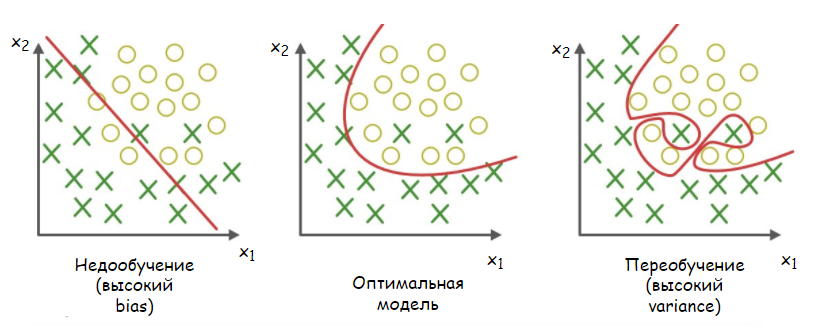

На рисунке выше изображены три различные модели:

- первая — простая логистическая регрессия;
- вторая — логистическая регрессия, обученная на полиномиальных признаках второй степени;
- третья — логистическая регрессия, обученная на полиномиальных признаках десятой степени.
  
Видно, что первая модель обладает низким качеством и не обобщает общей зависимости (у неё высокое смещение). Третья же, напротив, идеально выделяет каждое наблюдение в правильный класс, но является переобученной и также не отражает общей зависимости (у неё высокий разброс). Оптимальной моделью является вторая, которая не подстраивается под индивидуальные наблюдения и отражает общую зависимость в данных.